In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('outs/balanced.csv')

In [18]:
df.drop(['BMI_missing', 'Systolic Average', 'Diastolic Average'], axis=1, inplace=True)

In [19]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [20]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# split into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=447)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio),
                                                random_state=42)

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# prepare for dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_classes = len(np.unique(y))
dropout = 0.4

model = MLP(input_size, hidden_size, num_classes, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

In [22]:
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [1/100], Train Loss: 0.6987, Train Accuracy: 0.5425, Val Loss: 0.6332, Val Accuracy: 0.6687
Epoch [2/100], Train Loss: 0.6277, Train Accuracy: 0.6379, Val Loss: 0.5933, Val Accuracy: 0.6908
Epoch [3/100], Train Loss: 0.5993, Train Accuracy: 0.6727, Val Loss: 0.5835, Val Accuracy: 0.6910
Epoch [4/100], Train Loss: 0.5849, Train Accuracy: 0.6889, Val Loss: 0.5505, Val Accuracy: 0.7243
Epoch [5/100], Train Loss: 0.5736, Train Accuracy: 0.7004, Val Loss: 0.5580, Val Accuracy: 0.6943
Epoch [6/100], Train Loss: 0.5659, Train Accuracy: 0.7097, Val Loss: 0.5429, Val Accuracy: 0.7250
Epoch [7/100], Train Loss: 0.5582, Train Accuracy: 0.7181, Val Loss: 0.5533, Val Accuracy: 0.7265
Epoch [8/100], Train Loss: 0.5536, Train Accuracy: 0.7205, Val Loss: 0.5307, Val Accuracy: 0.7348
Epoch [9/100], Train Loss: 0.5493, Train Accuracy: 0.7231, Val Loss: 0.5339, Val Accuracy: 0.7430
Epoch [10/100], Train Loss: 0.5451, Train Accuracy: 0.7280, Val Loss: 0.5310, Val Accuracy: 0.7383
Epoch [11/100], Tra

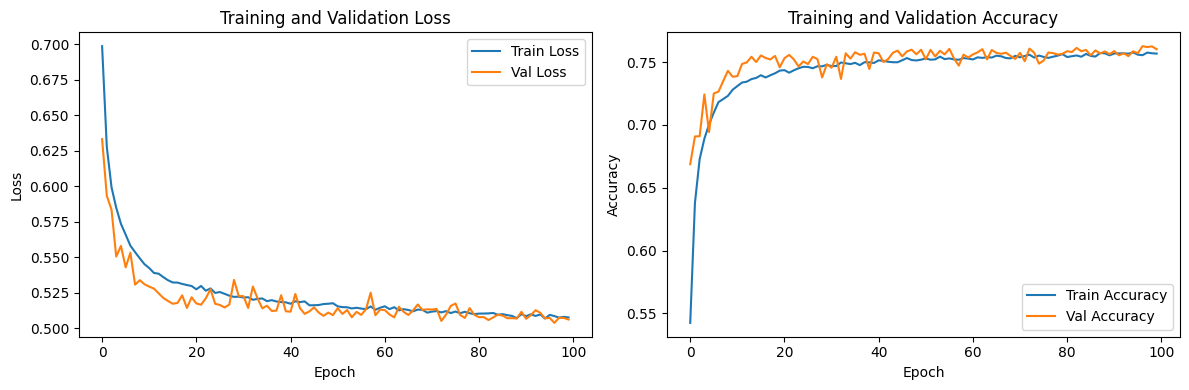

In [23]:
# plot loss and acc curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

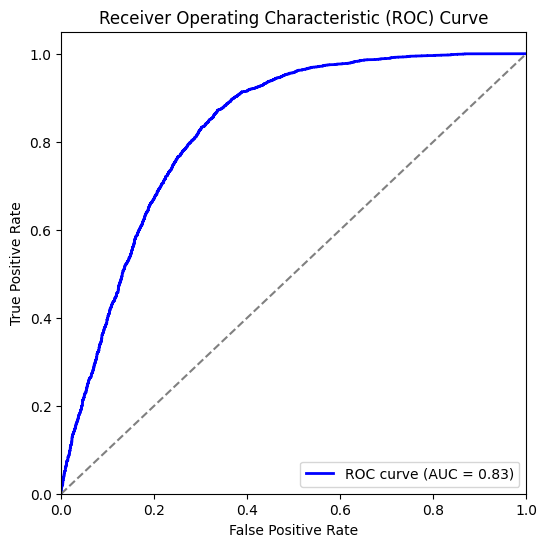

In [ ]:
from sklearn.metrics import roc_curve, auc
y_probs = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
y_pred_prob = np.exp(y_probs)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

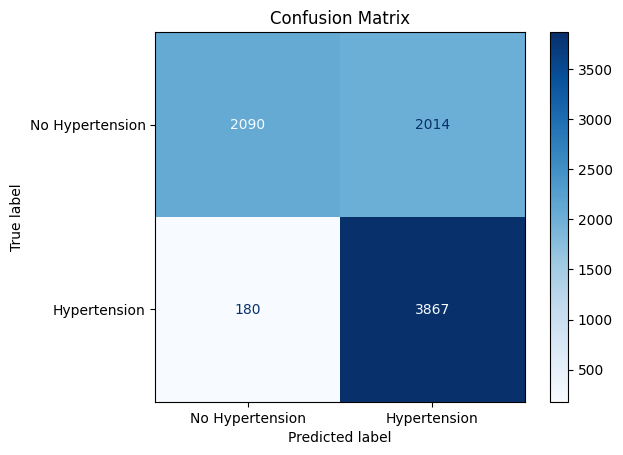

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Hypertension", "Hypertension"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["No Hypertension", "Hypertension"]))

                 precision    recall  f1-score   support

No Hypertension       0.92      0.51      0.66      4104
   Hypertension       0.66      0.96      0.78      4047

       accuracy                           0.73      8151
      macro avg       0.79      0.73      0.72      8151
   weighted avg       0.79      0.73      0.72      8151

